Two methods are used for this task, the first is preprocessing the data to remove stop words as well as check against common positive words, the second is just to extract the positve scores of un processed text to see the difference

In [1]:
import spacy
from spacy.lang.en import English
import nltk
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from statistics import mean
from sklearn.model_selection import train_test_split, GridSearchCV
import gensim
from gensim import corpora
from tqdm import tqdm
import pandas as pd
import numpy as np
import random
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
from gtts import gTTS
import IPython
nltk.download("wordnet")
nltk.download("stopwords")
nltk.download("vader_lexicon")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jackd\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jackd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jackd\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
#Read the data into a dataframe
file = pd.read_csv(r'./data_assessment_2/data_for_sentiment_analyzis/amazon_reviews.csv')
df = pd.DataFrame(file)
df

,sentiments,cleaned_review,cleaned_review_length,review_score
0,positive,i wish would have gotten one earlier love it a...,19,5.0
1,neutral,i ve learned this lesson again open the packag...,88,1.0
2,neutral,it is so slow and lags find better option,9,2.0
3,neutral,roller ball stopped working within months of m...,12,1.0
4,neutral,i like the color and size but it few days out ...,21,1.0
...,...,...,...,...
17335,positive,i love this speaker and love can take it anywh...,30,5.0
17336,positive,i use it in my house easy to connect and loud ...,13,4.0
17337,positive,the bass is good and the battery is amazing mu...,41,5.0
17338,positive,love it,2,5.0


In [3]:
print('Positive samples = ',len(df[df['sentiments'] == 'positive'])) #Check spread of data
print('Negative samplees = ',len(df[df['sentiments'] == 'negative']))
print('Neutral samples = ',len(df[df['sentiments'] == 'neutral']))

Positive samples =  9503
Negative samplees =  1534
Neutral samples =  6303


In [4]:
#DropNA does not catch blanks that need to be reomve for the feature extraction to work
#Instead i drop all columns in the list
df = df.drop([2085, 2894, 4333, 6043, 6841, 9526, 10063, 11388, 12912, 14435, 15481, 15557, 16222, 16495, 16502, 16529, 16802, 16911, 17281])
#Remove blank reviews for tokenization
df = df.reset_index(drop=True)

df

,sentiments,cleaned_review,cleaned_review_length,review_score
0,positive,i wish would have gotten one earlier love it a...,19,5.0
1,neutral,i ve learned this lesson again open the packag...,88,1.0
2,neutral,it is so slow and lags find better option,9,2.0
3,neutral,roller ball stopped working within months of m...,12,1.0
4,neutral,i like the color and size but it few days out ...,21,1.0
...,...,...,...,...
17316,positive,i love this speaker and love can take it anywh...,30,5.0
17317,positive,i use it in my house easy to connect and loud ...,13,4.0
17318,positive,the bass is good and the battery is amazing mu...,41,5.0
17319,positive,love it,2,5.0


In [5]:
stop_words = nltk.corpus.stopwords.words('english')
positive_reviews = []
negative_reviews = []
neutral_reviews = []
for i in tqdm(range(len(df))):#Loop through dataframe
    if df.loc[i,'sentiments'] == 'positive':#check sentiment tag
        pos_word = df.loc[i, 'cleaned_review']#selects the cleaned review text
        pos_word = word_tokenize(pos_word) #tokenize reivew
        pos_word = [word.lower() for word in pos_word] #converts tokens to lower case
        pos_word = [word for word in pos_word if word not in stop_words] #remove stop words
        positive_reviews.append(pos_word)#append preprocessed review
    elif df.loc[i,'sentiments'] == 'negative':
        neg_word = df.loc[i, 'cleaned_review']
        neg_word = word_tokenize(neg_word)
        neg_word = [word.lower() for word in neg_word]
        neg_word = [word for word in neg_word if word not in stop_words]
        negative_reviews.append(neg_word)
    elif df.loc[i,'sentiments'] == 'neutral':
        neutral_word = df.loc[i, 'cleaned_review']
        neutral_word = word_tokenize(neutral_word)
        neutral_word = [word.lower() for word in neutral_word]
        neutral_word = [word for word in neutral_word if word not in stop_words]
        neutral_reviews.append(neutral_word)
    else:
        print("Unrecgonised tag at index = ", i)

100%|██████████████████████████████████████████████████████████████████████████| 17321/17321 [00:02<00:00, 7713.53it/s]


In [6]:
all_posWords = []
all_negWords = []
all_neutralWords = []

for wordList in positive_reviews:
    all_posWords += wordList
    
for wordList in negative_reviews:
    all_negWords += wordList
    
for wordList in neutral_reviews:
    all_neutralWords += wordList

positive_fd = nltk.FreqDist(all_posWords)#frequency distribution for review words
negative_fd = nltk.FreqDist(all_negWords)
neutral_fd = nltk.FreqDist(all_neutralWords)

most_common_pos = {word for word, count in positive_fd.most_common(100)}#selects most common words in each dist
most_common_neg = {word for word, count in negative_fd.most_common(100)}
most_common_neutral = {word for word, count in neutral_fd.most_common(100)}

In [7]:
sia = SentimentIntensityAnalyzer()
def feat_extract1(text):#extracts sentiment of each review
    features = []
    wordcount = 0
    compound_scores = list()
    positive_scores = list()
    for sentence in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sentence):
            if word.lower() in most_common_pos:
                wordcount +=1
        compound_scores.append(sia.polarity_scores(sentence)["compound"])
        positive_scores.append(sia.polarity_scores(sentence)["pos"])#gets compound and postive score for prediction
    features.append(mean(compound_scores) +1)
    features.append(mean(positive_scores))
    features.append(wordcount)
    return features

In [8]:
pos_features = []
neg_features = []
neutral_features = []
pos_labels = []
neg_labels = []
neutral_labels = []

#Gather data for prediciton
for i in tqdm(range(len(df))):
    if df.loc[i, 'sentiments'] == 'positive':
        word = df.loc[i, 'cleaned_review']
        pos_features.append(feat_extract1(word))
        pos_labels.append('positive')
    elif df.loc[i, 'sentiments'] == 'negative':
        word = df.loc[i, 'cleaned_review']
        neg_features.append(feat_extract1(word))
        neg_labels.append('negative')
    elif df.loc[i, 'sentiments'] == 'neutral':
        word = df.loc[i, 'cleaned_review']
        neutral_features.append(feat_extract1(word))
        neutral_labels.append('neutral')

100%|██████████████████████████████████████████████████████████████████████████| 17321/17321 [00:09<00:00, 1840.37it/s]


To split the data i will split all the tags to a 70 30% split then add them to one big train list
This is to advoid any bias in the training with one sample having little to no representation

In [9]:
#Split the tree reviews in to 70 30 train test as mention above
pos_train_X, pos_test_X, pos_train_y, pos_test_y = train_test_split(pos_features, pos_labels, test_size=0.3)
neg_train_X, neg_test_X, neg_train_y, neg_test_y = train_test_split(neg_features, neg_labels, test_size=0.3)
neutral_train_X, neutral_test_X, neutral_train_y, neutral_test_y = train_test_split(neutral_features, neutral_labels, test_size=0.3)

In [15]:
train_features = []
train_features.extend(pos_train_X)
train_features.extend(neg_train_X)
train_features.extend(neutral_train_X)

train_labels = []
train_labels.extend(pos_train_y)
train_labels.extend(neg_train_y)
train_labels.extend(neutral_train_y)

test_features = []
test_features.extend(pos_test_X)
test_features.extend(neg_test_X)
test_features.extend(neutral_test_X)

test_labels = []
test_labels.extend(pos_test_y)
test_labels.extend(neg_test_y)
test_labels.extend(neutral_test_y)

In [16]:
c = list(zip(train_features, train_labels))
random.shuffle(c)
train_features, train_labels = zip(*c)

c = list(zip(test_features, test_labels))
random.shuffle(c)
test_features, test_labels = zip(*c)

#Shuffles the data and labels keeping each postion matched so it can be used to evalute the classifer

In [17]:
train_features = np.array(train_features)
train_labels = np.array(train_labels)
test_features = np.array(test_features)
test_labels = np.array(test_labels)#conver to np arrays

Hyper Parameter Training can take a while to run so dont run it everytime

In [18]:
param = {'C': [1, 10, 100], 'gamma': [0.001, 0.0001], 'kernel': ['linear', 'rbf']} #set param to test
Tune_SVC = GridSearchCV(estimator=SVC(), param_grid=param, cv=10, scoring='accuracy') #establish classifier and params
Tune_SVC.fit(train_features, train_labels)#fits data to run on
print("Best Parameters:")
print(Tune_SVC.best_estimator_)

df_SVC = pd.DataFrame({'parameters':Tune_SVC.cv_results_["params"], 'Mean_Accuracy':Tune_SVC.cv_results_["mean_test_score"]})
df_SVC#gathers the data into a daatframe for easy viewing

KeyboardInterrupt: 

Prediction accuracy = 0.9774913428241632


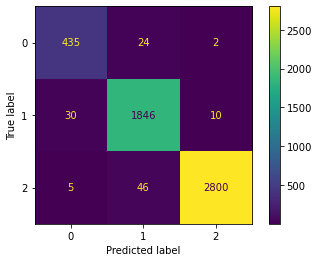

In [19]:
clf = SVC(C=1, gamma=0.001, kernel='linear')#build and test classifier
clf.fit(train_features, train_labels)

predict = clf.predict(test_features)

matrix = confusion_matrix(test_labels, predict)
cm_display = ConfusionMatrixDisplay(confusion_matrix= matrix)

print('Prediction accuracy =', accuracy_score(test_labels, predict))
cm_display.plot()
plt.show()

Second method - Count vecotrize

In [16]:
matrix = CountVectorizer(max_features=100)#counter vector of reviews
X = matrix.fit_transform(df['cleaned_review']).toarray()
X

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [18]:
lables = df['sentiments']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, lables, test_size=0.3)#split into test train

Prediction accuracy = 0.7061766403694439


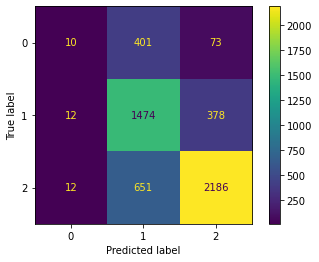

In [21]:
clf2 = SVC(C=1, gamma=0.001, kernel='linear')#classifier for second method
clf2.fit(X_train, y_train)

predict2 = clf2.predict(X_test)

matrix2 = confusion_matrix(y_test, predict2)
cm_display2 = ConfusionMatrixDisplay(confusion_matrix= matrix2)

print('Prediction accuracy =', accuracy_score(y_test, predict2))
cm_display2.plot()
plt.show()

In [ ]:
User_Query = input("What review would you like to check ")#ask user for query they wish to check sentiment for
user_features = feat_extract1(User_Query)
user_features = np.array(user_features)
user_features = user_features.reshape(1,-1)
prediction = clf.predict(user_features)
print("The review you entered is ",prediction)

In [21]:
#Text to be read
text = """The review you have entered is {User_Query}. The sentiment of
this review seems overall {prediction}.
""".format(User_Query = User_Query, prediction = prediction)

filename = "Assessment3.mp3"#Text saved to file
tts = gTTS(text, lang="en", tld='co.uk', slow=False)
tts.save(filename)
IPython.display.Audio(filename,autoplay=True)#Read text above